In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

# =======================================================
# PREVIEW DATASET
# =======================================================
df = pd.read_csv("/content/covid_19_indonesia_time_series_all.csv")

print("=== [DESKRIPSI DATASET] ===")
print(f"Jumlah baris total      : {len(df)}")
print(f"Jumlah kolom            : {len(df.columns)}")
print("Nama kolom :")
print(list(df.columns))
print("\n 5 baris pertama dataset :")

cols_preview = [
    "Date", "Location", "Location ISO Code",
    "New Cases", "New Deaths", "New Recovered", "New Active Cases",
    "Total Cases", "Total Deaths", "Total Recovered", "Total Active Cases"
]

print(df[cols_preview].head())
print("\n====================================================\n")

# =======================================================
# FILTER LOKASI 'INDONESIA'
# =======================================================
df_idn = df[df["Location"] == "Indonesia"].copy()

df_idn["Date"] = pd.to_datetime(df_idn["Date"])
df_idn = df_idn.sort_values("Date").reset_index(drop=True)

print("=== [SETELAH FILTER Location = 'Indonesia'] ===")
print(f"Jumlah baris (Indonesia) : {len(df_idn)}")
print("Rentang tanggal          :",
      df_idn["Date"].min().date(), "sampai", df_idn["Date"].max().date())
print(df_idn[["Date", "Location", "Total Cases",
              "Total Recovered", "Total Deaths",
              "Total Active Cases"]].head())
print()

# =======================================================
# PILIH KOLOM PENTING
# =======================================================
cols_need = [
    "Date",
    "Total Cases",
    "Total Recovered",
    "Total Deaths",
    "Total Active Cases"
]
df_idn = df_idn[cols_need].copy()

# =======================================================
# CEK KONSISTENSI ACTIVE CASES
# =======================================================
df_idn["Active_calc"] = (
    df_idn["Total Cases"]
    - df_idn["Total Recovered"]
    - df_idn["Total Deaths"]
)

is_consistent = (df_idn["Active_calc"] == df_idn["Total Active Cases"]).all()

print("=== [CEK KONSISTENSI ACTIVE CASES] ===")
print("Apakah konsisten dengan rumus (Total - Recovered - Deaths)? ->", is_consistent)
print("\nContoh 5 baris pertama:")
print(df_idn[[ "Date", "Total Cases", "Total Recovered",
              "Total Deaths", "Total Active Cases", "Active_calc"
]].head())
print()


# =======================================================
# DERET WAKTU ACTIVE CASES
# =======================================================
df_idn["Active"] = df_idn["Total Active Cases"].astype(float)
data_series = df_idn[["Date", "Active"]].copy()

print("=== [DERET WAKTU ACTIVE CASES] ===")
print("5 baris pertama:")
print(data_series.head(), "\n")

print("5 baris terakhir:")
print(data_series.tail(), "\n")

print(f"Jumlah total baris deret waktu: {len(data_series)}")
print("===============================================\n")


=== [DESKRIPSI DATASET] ===
Jumlah baris total      : 31822
Jumlah kolom            : 38
Nama kolom :
['Date', 'Location ISO Code', 'Location', 'New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases', 'Location Level', 'City or Regency', 'Province', 'Country', 'Continent', 'Island', 'Time Zone', 'Special Status', 'Total Regencies', 'Total Cities', 'Total Districts', 'Total Urban Villages', 'Total Rural Villages', 'Area (km2)', 'Population', 'Population Density', 'Longitude', 'Latitude', 'New Cases per Million', 'Total Cases per Million', 'New Deaths per Million', 'Total Deaths per Million', 'Total Deaths per 100rb', 'Case Fatality Rate', 'Case Recovered Rate', 'Growth Factor of New Cases', 'Growth Factor of New Deaths']

 5 baris pertama dataset :
       Date     Location Location ISO Code  New Cases  New Deaths  \
0  3/1/2020  DKI Jakarta             ID-JK          2           0   
1  3/2/2020  DKI Jakarta 

In [ ]:
# HANDLE NaN
print("=== CEK & TANGANI MISSING VALUE ===")
print("Jumlah NaN sebelum diisi :", data_series["Active"].isna().sum())

data_series["Active"] = (
    data_series["Active"]
    .interpolate(method="linear")
    .ffill()
    .bfill()
)

print("Jumlah NaN sesudah diisi :", data_series["Active"].isna().sum())
print("Contoh nilai setelah interpolasi:")
print(data_series.head())
print()


=== CEK & TANGANI MISSING VALUE ===
Jumlah NaN sebelum diisi : 0
Jumlah NaN sesudah diisi : 0
Contoh nilai setelah interpolasi:
        Date  Active
0 2020-03-02     2.0
1 2020-03-03     2.0
2 2020-03-04     2.0
3 2020-03-05     2.0
4 2020-03-06     4.0



In [ ]:
# =======================================================
# NORMALISASI DATA ACTIVE CASES (MIN-MAX)
# =======================================================

series = data_series["Active"].values.astype("float32")

min_val = series.min()
max_val = series.max()

print("=== [INFORMASI SKALA AWAL] ===")
print(f"Nilai minimum Active : {min_val}")
print(f"Nilai maksimum Active: {max_val}")
print()

# Normalisasi ke rentang [0, 1]
series_scaled = (series - min_val) / (max_val - min_val)

print("=== [10 NILAI PERTAMA SETELAH NORMALISASI] ===")
print("Skala asli    :", series[:10].astype(int))
print("Skala [0,1]   :", np.round(series_scaled[:10], 6))
print("================================================\n")


=== [INFORMASI SKALA AWAL] ===
Nilai minimum Active : 2.0
Nilai maksimum Active: 586113.0

=== [10 NILAI PERTAMA SETELAH NORMALISASI] ===
Skala asli    : [ 2  2  2  2  4  4  6 19 25 31]
Skala [0,1]   : [0.0e+00 0.0e+00 0.0e+00 0.0e+00 3.0e-06 3.0e-06 7.0e-06 2.9e-05 3.9e-05
 4.9e-05]



In [ ]:
import numpy as np

# ================================
# BENTUK DATA SUPERVISED
# ================================
def create_supervised(series_1d, lag=7):
    X, y = [], []
    for i in range(lag, len(series_1d)):
        X.append(series_1d[i - lag:i])   # input: lag hari sebelumnya
        y.append(series_1d[i])           # target: hari ke-(lag+1)
    return np.array(X), np.array(y)


lag = 7
X, y = create_supervised(series_scaled, lag=lag)

print("=== [BENTUK DATA SUPERVISED — LAG = 7] ===")
print(f"Shape X : {X.shape}  (n_sample, {lag})")
print(f"Shape y : {y.shape}  (n_sample, )\n")

# ================================
# CONTOH 1 SAMPEL
# ================================
idx = 0      # ambil sampel pertama

dates_window   = data_series["Date"].values[idx:idx + lag + 1]
orig_window    = series[idx:idx + lag + 1].astype(int)
scaled_window  = series_scaled[idx:idx + lag + 1]

print("Contoh 1 sampel (lag 7 hari):")
for i in range(lag):
    d = pd.to_datetime(dates_window[i]).strftime("%Y-%m-%d")
    print(
        f"  Hari ke-{i+1:>2} (t-{lag-i}) | "
        f"Tanggal = {d} | "
        f"Active = {orig_window[i]:6d} | "
        f"Scaled = {scaled_window[i]:.6f}"
    )

d_target = pd.to_datetime(dates_window[-1]).strftime("%Y-%m-%d")
print(
    f"=> Target (hari ke-8, t)  | "
    f"Tanggal = {d_target} | "
    f"Active = {orig_window[-1]:6d} | "
    f"Scaled = {scaled_window[-1]:.6f}"
)
print("============================================\n")


=== [BENTUK DATA SUPERVISED — LAG = 7] ===
Shape X : (922, 7)  (n_sample, 7)
Shape y : (922,)  (n_sample, )

Contoh 1 sampel (lag 7 hari):
  Hari ke- 1 (t-7) | Tanggal = 2020-03-02 | Active =      2 | Scaled = 0.000000
  Hari ke- 2 (t-6) | Tanggal = 2020-03-03 | Active =      2 | Scaled = 0.000000
  Hari ke- 3 (t-5) | Tanggal = 2020-03-04 | Active =      2 | Scaled = 0.000000
  Hari ke- 4 (t-4) | Tanggal = 2020-03-05 | Active =      2 | Scaled = 0.000000
  Hari ke- 5 (t-3) | Tanggal = 2020-03-06 | Active =      4 | Scaled = 0.000003
  Hari ke- 6 (t-2) | Tanggal = 2020-03-07 | Active =      4 | Scaled = 0.000003
  Hari ke- 7 (t-1) | Tanggal = 2020-03-08 | Active =      6 | Scaled = 0.000007
=> Target (hari ke-8, t)  | Tanggal = 2020-03-09 | Active =     19 | Scaled = 0.000029



In [ ]:
# ================================
# SPLIT DATA: TRAIN / VAL / TEST
# ================================
n_sample = len(X)

# 70% train, 15% val, 15% test
train_end = int(0.7 * n_sample)
val_end   = int(0.85 * n_sample)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],          y[val_end:]

print("=== [RINGKASAN SPLIT DATA] ===")
print(f"Total sampel supervised : {n_sample}")
print(f"Train : {X_train.shape}  (~70%)")
print(f"Val   : {X_val.shape}    (~15%)")
print(f"Test  : {X_test.shape}   (~15%)")
print()

# --------------------------------
# INFO RENTANG TANGGAL PER SUBSET
# --------------------------------
# Setelah dibentuk supervised dengan lag=7,
# setiap baris X,y berpasangan dengan 1 tanggal (hari ke-t).
dates_supervised = data_series["Date"].values[lag:]

def fmt(d):
    """Format tanggal jadi YYYY-MM-DD."""
    return pd.to_datetime(d).strftime("%Y-%m-%d")

print("Rentang tanggal per subset:")
print(f"Train : {fmt(dates_supervised[0])}        s.d. {fmt(dates_supervised[train_end-1])}")
print(f"Val   : {fmt(dates_supervised[train_end])} s.d. {fmt(dates_supervised[val_end-1])}")
print(f"Test  : {fmt(dates_supervised[val_end])}   s.d. {fmt(dates_supervised[-1])}")
print("========================================\n")


=== [RINGKASAN SPLIT DATA] ===
Total sampel supervised : 922
Train : (645, 7)  (~70%)
Val   : (138, 7)    (~15%)
Test  : (139, 7)   (~15%)

Rentang tanggal per subset:
Train : 2020-03-09        s.d. 2021-12-13
Val   : 2021-12-14 s.d. 2022-04-30
Test  : 2022-05-01   s.d. 2022-09-16



In [ ]:
import numpy as np

# ==========================
# AKTIVASI
# ==========================
def relu(x):
    """Fungsi aktivasi ReLU."""
    return np.maximum(0, x)

def d_relu(x):
    """Turunan ReLU (untuk backprop)."""
    return (x > 0).astype(float)


# ==========================
# FORWARD PASS
# ==========================
def forward(X, W, B):
    """
    Forward pass jaringan.
    Input:
      - X : (m, input_dim)
      - W : list bobot antar layer
      - B : list bias antar layer
    Output:
      - a : list aktivasi tiap layer (a[0] = X, a[-1] = output)
      - z : list net input sebelum aktivasi (per layer hidden & output)
    """
    a = [X]   # aktivasi (layer 0 = input)
    z = []    # net input

    for i in range(len(W)):
        net = a[i] @ W[i] + B[i]   # z = a_prev * W + b
        z.append(net)

        if i < len(W) - 1:
            out = relu(net)        # hidden layer pakai ReLU
        else:
            out = net              # output layer linear

        a.append(out)

    return a, z


# ==========================
# BACKPROP: HITUNG GRADIENT
# ==========================
def backprop_grad(a, z, W, y):
    """
    Menghitung gradien bobot & bias dengan backpropagation.
    Input:
      - a : list aktivasi tiap layer (hasil forward)
      - z : list net input tiap layer
      - W : list bobot
      - y : target (m, out_dim)
    Output:
      - grad_W : list gradien bobot
      - grad_B : list gradien bias
    """
    L = len(W)          # jumlah layer bobot
    m = y.shape[0]      # jumlah sampel

    delta  = [None] * L
    grad_W = [None] * L
    grad_B = [None] * L

    # Delta output (MSE + output linear):
    # dL/dy_hat = (y_hat - y)
    delta[-1] = (a[-1] - y)    # shape: (m, out_dim)

    # Delta hidden (ReLU) – chain rule mundur
    for i in reversed(range(L - 1)):
        delta[i] = (delta[i + 1] @ W[i + 1].T) * d_relu(z[i])

    # Gradien bobot & bias (dirata-rata per sampel)
    for i in range(L):
        grad_W[i] = (a[i].T @ delta[i]) / m
        grad_B[i] = np.mean(delta[i], axis=0, keepdims=True)

    return grad_W, grad_B


# ==========================
# TRAINING DENGAN ADAM
# ==========================
def bp_fit_adam(
    X,
    y,
    layer_conf,
    max_epoch=1000,
    lr=0.001,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    print_per=50,
):
    """
    Pelatihan jaringan MLP dengan backpropagation + Adam.
    layer_conf: tuple jumlah neuron per layer, misal (7, 32, 16, 1).
    """
    # --- Inisialisasi bobot & bias ---
    W = []
    B = []
    for i in range(len(layer_conf) - 1):
        in_dim  = layer_conf[i]
        out_dim = layer_conf[i + 1]
        W.append(np.random.randn(in_dim, out_dim) * 0.1)
        B.append(np.zeros((1, out_dim)))

    # --- Inisialisasi m dan v (moment) untuk Adam ---
    mW = [np.zeros_like(W[i]) for i in range(len(W))]
    vW = [np.zeros_like(W[i]) for i in range(len(W))]
    mB = [np.zeros_like(B[i]) for i in range(len(B))]
    vB = [np.zeros_like(B[i]) for i in range(len(B))]

    mse_list = []
    t = 0  # time step Adam

    print("=== [TRAINING BACKPROP + ADAM] ===")
    print(f"Konfigurasi layer : {layer_conf}")
    print(f"Learning rate     : {lr}")
    print(f"Max epoch         : {max_epoch}\n")

    for epoch in range(1, max_epoch + 1):
        t += 1

        # ----- Forward -----
        a, z = forward(X, W, B)
        y_pred = a[-1]

        # ----- Hitung MSE -----
        mse = np.mean((y_pred - y) ** 2)
        mse_list.append(mse)

        # ----- Gradien dari backprop -----
        grad_W, grad_B = backprop_grad(a, z, W, y)

        # ----- Update parameter dengan Adam -----
        for i in range(len(W)):
            # 1) update moment bobot
            mW[i] = beta1 * mW[i] + (1 - beta1) * grad_W[i]
            vW[i] = beta2 * vW[i] + (1 - beta2) * (grad_W[i] ** 2)

            # 2) bias correction
            mW_hat = mW[i] / (1 - beta1 ** t)
            vW_hat = vW[i] / (1 - beta2 ** t)

            # 3) update bobot
            W[i] -= lr * mW_hat / (np.sqrt(vW_hat) + eps)

            # 4) update moment bias
            mB[i] = beta1 * mB[i] + (1 - beta1) * grad_B[i]
            vB[i] = beta2 * vB[i] + (1 - beta2) * (grad_B[i] ** 2)

            # 5) bias correction bias
            mB_hat = mB[i] / (1 - beta1 ** t)
            vB_hat = vB[i] / (1 - beta2 ** t)

            # 6) update bias
            B[i] -= lr * mB_hat / (np.sqrt(vB_hat) + eps)

        # Print progress tiap beberapa epoch
        if print_per > 0 and epoch % print_per == 0:
            print(f"Epoch {epoch:4d} | MSE: {mse:.6f}")

    print("\nTraining selesai.")
    print(f"MSE akhir (epoch {max_epoch}) : {mse_list[-1]:.6f}")
    print("====================================\n")

    return W, B, mse_list

In [ ]:
layer_conf = (7, 32, 16, 1)

y_train_col = y_train.reshape(-1, 1)

W, B, mse = bp_fit_adam(
    X_train,
    y_train_col,
    layer_conf=layer_conf,
    max_epoch=2000,
    lr=0.001,
    print_per=50,
)

=== [TRAINING BACKPROP + ADAM] ===
Konfigurasi layer : (7, 32, 16, 1)
Learning rate     : 0.001
Max epoch         : 2000

Epoch   50 | MSE: 0.017174
Epoch  100 | MSE: 0.000887
Epoch  150 | MSE: 0.000747
Epoch  200 | MSE: 0.000621
Epoch  250 | MSE: 0.000458
Epoch  300 | MSE: 0.000311
Epoch  350 | MSE: 0.000198
Epoch  400 | MSE: 0.000124
Epoch  450 | MSE: 0.000086
Epoch  500 | MSE: 0.000070
Epoch  550 | MSE: 0.000064
Epoch  600 | MSE: 0.000063
Epoch  650 | MSE: 0.000061
Epoch  700 | MSE: 0.000058
Epoch  750 | MSE: 0.000057
Epoch  800 | MSE: 0.000056
Epoch  850 | MSE: 0.000055
Epoch  900 | MSE: 0.000054
Epoch  950 | MSE: 0.000053
Epoch 1000 | MSE: 0.000052
Epoch 1050 | MSE: 0.000051
Epoch 1100 | MSE: 0.000050
Epoch 1150 | MSE: 0.000049
Epoch 1200 | MSE: 0.000047
Epoch 1250 | MSE: 0.000046
Epoch 1300 | MSE: 0.000045
Epoch 1350 | MSE: 0.000044
Epoch 1400 | MSE: 0.000043
Epoch 1450 | MSE: 0.000042
Epoch 1500 | MSE: 0.000041
Epoch 1550 | MSE: 0.000040
Epoch 1600 | MSE: 0.000039
Epoch 1650 | M

In [ ]:
# =======================================================
# PREDIKSI DAN EVALUASI DI DATA TEST
# =======================================================

# 1. Prediksi pada data test (skala [0,1])
a_test, z_test = forward(X_test, W, B)
y_pred_test_scaled = a_test[-1].reshape(-1)   # output layer

# 2. Kembalikan ke skala asli (jumlah kasus aktif)
y_test_real = y_test * (max_val - min_val) + min_val
y_pred_real = y_pred_test_scaled * (max_val - min_val) + min_val

# 3. Hitung RMSE & MAE
rmse = np.sqrt(np.mean((y_test_real - y_pred_real) ** 2))
mae  = np.mean(np.abs(y_test_real - y_pred_real))

print("=== HASIL EVALUASI (Adam) DI DATA TEST ===")
print(f"RMSE (kasus aktif): {rmse:10.3f}")
print(f"MAE  (kasus aktif): {mae:10.3f}")
print("==========================================\n")

# 4. Tampilkan 5 sampel pertama (aktual vs prediksi)
print("Contoh 5 sampel pertama (aktual vs prediksi):")
print(f"{'Idx':>3} | {'Aktual':>12} | {'Prediksi':>12} | {'Selisih':>10}")
print("-" * 47)

for i in range(5):
    actual  = y_test_real[i]
    pred    = y_pred_real[i]
    diff    = pred - actual
    print(f"{i+1:3d} | {actual:12.1f} | {pred:12.1f} | {diff:10.1f}")


=== HASIL EVALUASI (Adam) DI DATA TEST ===
RMSE (kasus aktif):    867.444
MAE  (kasus aktif):    600.613

Contoh 5 sampel pertama (aktual vs prediksi):
Idx |       Aktual |     Prediksi |    Selisih
-----------------------------------------------
  1 |       7474.0 |       6450.8 |    -1023.2
  2 |       7257.0 |       6840.4 |     -416.6
  3 |       6951.0 |       6933.1 |      -17.9
  4 |       6845.0 |       6730.8 |     -114.2
  5 |       6631.0 |       6654.2 |       23.2


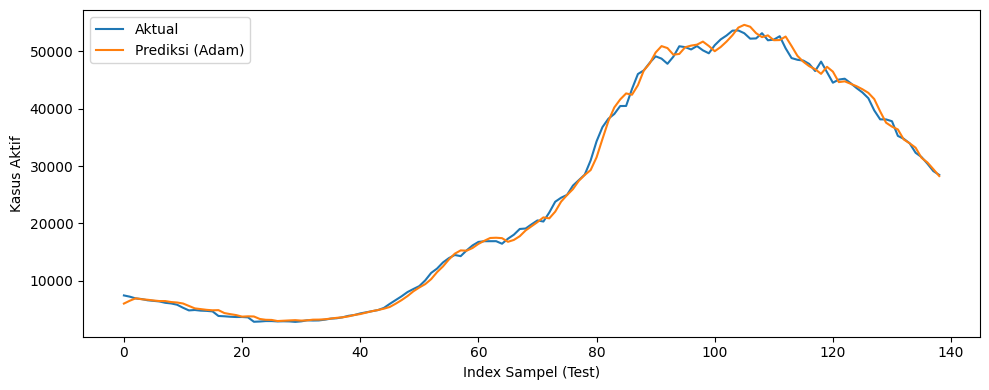

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test_real, label="Aktual")
plt.plot(y_pred_real, label="Prediksi (Adam)")
plt.xlabel("Index Sampel (Test)")
plt.ylabel("Kasus Aktif")
plt.legend()
plt.tight_layout()
plt.show()
